# Computing communities in large networks using random walks

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
import copy
%matplotlib inline

## Generate the graph

**Run only one of the following cells, depending on which graph you want to cluster**

In [112]:
# Create a random graph
N = 320
num_clusters = 4
A = np.eye(N, dtype=int)
p_in = 0.99
p_out = 0.05

#assign clusters to edges
# # random assignement
# cluster_assignements = np.random.randint(num_clusters, size=N)
# same number for each cluster
cluster_assignements = np.repeat(np.arange(num_clusters), int(N/num_clusters))

# create random edges
for i in range(N):
    for j in range(i, N):
        p = p_in if cluster_assignements[i] == cluster_assignements[j] else p_out
        A[i,j] = max(A[i,j], p > np.random.rand())
        A[j,i] = A[i,j]

In [268]:
# Graph example from the paper
N = 16
num_clusters = 2
A = np.eye(N, dtype=int)
cluster_assignements = np.array([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0])
edges = [
    (0,4),
    (0,6),
    (1,2),
    (1,3),
    (1,4),
    (1,8),
    (2,3),
    (2,4),
    (2,5),
    (2,7),
    (3,6),
    (4,5),
    (5,6),
    (5,9),
    (6,7),
    (7,9),
    (8,9),
    (8,10),
    (8,11),
    (8,12),
    (8,14),
    (9,10),
    (9,14),
    (11,13),
    (12,13),
    (12,14),
    (13,14),
    (14,15)
]
for (i,j) in edges:
    A[i,j] = 1
    A[j,i] = 1

In [155]:
#Karathe Club dataset
G=nx.karate_club_graph()
num_clusters = 2
A = np.array(nx.adjacency_matrix(G).todense())
N = A.shape[0]
for i in range(N):
    A[i,i] = 1
cluster_assignements = np.array([1 if G.node[i]['club'] == 'Mr. Hi' else 0 for i in range(N)])

In [520]:
#florentine family graph
G=nx.florentine_families_graph()
num_clusters = 2
A = np.array(nx.adjacency_matrix(G).todense())
N = A.shape[0]
for i in range(N):
    A[i,i] = 1

In [197]:
#college football network
G = nx.read_gml('./datasets/college_football.gml')
num_clusters = 12

cluster_assignements = []
for node in G.node.values():
    cluster_assignements.append(node['value'])
cluster_assignements = np.array(cluster_assignements)

A = np.array(nx.adjacency_matrix(G).todense())
N = A.shape[0]
for i in range(N):
    A[i,i] = 1

[[8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7]]


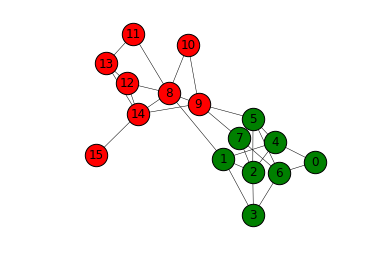

In [269]:
#draw the graph
def draw_graph(clusters, num_clusters):
    plt.axis('off')
    colors = ['r', 'g', 'b', 'y', 'b']
    G = nx.from_numpy_matrix(A)
    pos = nx.spring_layout(G)
    for i in range(num_clusters):
        nx.draw_networkx_nodes(G, pos, nodelist=clusters[i], node_color=colors[i % len(colors)], node_size=500, alpha=1)
    # nx.draw_networkx_nodes(G, pos, nodelist=cluster2_nodes, node_color='g', node_size=500, alpha=1)
    nx.draw_networkx_edges(G, pos, width=0.5)
    nx.draw_networkx_labels(G, pos, {i:i for i in range(N)})

cluster_nodes = [list(np.where(cluster_assignements == i)[0]) for i in range(num_clusters)] 
print(cluster_nodes)
draw_graph(cluster_nodes, num_clusters)
# plt.savefig("plots/karate_graph")

## Computing distances

In [270]:
# Compute helper matrices
degrees = np.sum(A, axis=1)
D_inv = np.diag(1/degrees)
D_inv_sqrt = np.diag(1/np.sqrt(degrees))

#compute the number of edges
M = (np.sum(A) + N) / 2

# def distance(P_i, P_j):
#     return np.sqrt(np.sum(((P_i - P_j) ** 2) / degrees))

def distance(P_i, P_j):
    return np.sqrt(np.sum((np.dot(D_inv_sqrt, P_i) - np.dot(D_inv_sqrt, P_j)) ** 2))

def Δσ(l1, P_1, l2, P_2):
    return 1 / N * l1 * l2 / (l1 + l2) * (distance(P_1,P_2) ** 2)

## Hierarchical clustering

### Helper functions

In [271]:
#find the two clusters C1 and C2 with the smallest Δσ(C1, C2)
def find_to_merge(clusters):
    # find minimum Δσ for two clusters
    min_Δσ = None
    to_merge = None
    for i, cluster in clusters.items():
        for j, dist in cluster['neighbours'].items():
            if min_Δσ == None or dist < min_Δσ:
                min_Δσ = dist
                to_merge = (i, j)
    return (to_merge[0], to_merge[1], min_Δσ)

In [272]:
# Given clusters, merge C1 and C2 into a new cluster with id new_id
def merge_clusters(clusters, i, j, new_id):
    C1 = clusters[i]
    C2 = clusters[j]
    C3 = {}
    
    l1 = len(C1['nodes'])
    l2 = len(C2['nodes'])
    # Create new Cluster, merging C1 and C2
    C3['nodes'] = C1['nodes'].union(C2['nodes'])
    
    #compute the P_t for the new cluster
    C3['P_t'] = (l1 * C1['P_t'] + l2 * C2['P_t']) / (l1 + l2)

    new_neighbours = set(C1['neighbours'].keys()).union(set(C2['neighbours'].keys()))
    new_neighbours.remove(i)
    new_neighbours.remove(j)
    
    # Compute Δσ's for the new cluster
    C3['neighbours'] = {}
    for n in new_neighbours:
        C = clusters[n]
        l3 = len(C['nodes'])
        if n in C1['neighbours'].keys() and n in C2['neighbours'].keys():
            #apply Theorem 4
            x_A = (l1 + l3) * C1['neighbours'][n]
            x_B = (l2 + l3) * C2['neighbours'][n]
            x_C = (l3) * C1['neighbours'][j]
            new_Δσ = (x_A + x_B - x_C) / (l1 + l2 + l3)
        else:
            #apply Theorem 3
            new_Δσ = Δσ(l1+l2, C3['P_t'], l3, C['P_t'])
        
        C3['neighbours'][n] = new_Δσ
        C['neighbours'].pop(i, None)
        C['neighbours'].pop(j, None)
        C['neighbours'][new_id] = new_Δσ
    
    clusters[new_id] = C3
    clusters.pop(i)
    clusters.pop(j)

### Create partitions

In [273]:
# Create transition matrix
np.set_printoptions(precision=2)
P = np.dot(D_inv, A)

In [274]:
#Compute probability vectors
t = 3
P_t = np.eye(N)
for i in range(t):
    P_t = np.dot(P, P_t)

In [275]:
#create initial clusters
A2 = A - np.eye(N)
clusters = {}
for i in range(N):
    neighbours = {}
    for j in range(N):
        if i != j and A[i,j] :
            neighbours[j] = Δσ(1, P_t[i], 1, P_t[j])
    clusters[i] = {
        'nodes': {i},
        'P_t': P_t[i],
        'neighbours': neighbours
    }
# merge clusters repeatedly
new_id = N

build_tree = []
cum_dist = 0

Δσs = []

partitions = []
partitions.append([C['nodes'] for C in clusters.values()]) # add initial paritition

while(len(clusters) > 1):    
    # find clusters to merge
    (i,j, min_Δσ) = find_to_merge(clusters)
    # Compute new partion
    merge_clusters(clusters, i, j, new_id)
    
    # For dendogram
    build_tree.append((new_id, i, j, cum_dist))
    cum_dist += min_Δσ
    
    # Keep track of partitions
    partitions.append([C['nodes'] for C in clusters.values()])
    
    # For evaluation of partitions
    Δσs.append(min_Δσ)
    
    new_id += 1

## Evaluate partitions and choose the optimal one

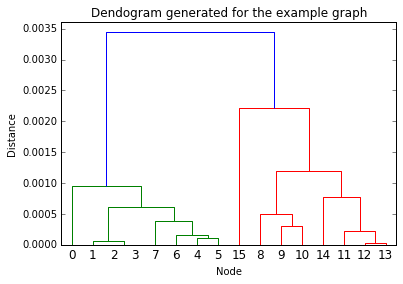

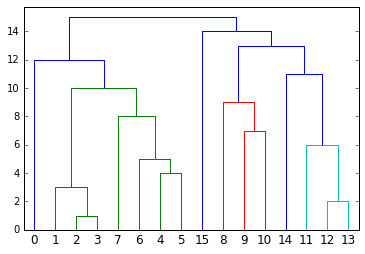

In [288]:
#create linkage matrix
Z = np.array([[id1, id2, dist, 0] for (j, (new_id, id1, id2, dist)) in enumerate(build_tree)], dtype=np.double)
dendrogram(Z);
plt.xlabel("Node")
plt.ylabel("Distance")
plt.title("Dendogram generated for the example graph")
plt.savefig("plots/toy_graph_dendogram")
plt.figure()
Z = np.array([[id1, id2, j+1, 0] for (j, (new_id, id1, id2, dist)) in enumerate(build_tree)], dtype=np.double)
dendrogram(Z);

In [277]:
# Compute the modularity of a given partition
def modularity(partition):
    def edge_fraction(C1, C2):
        sum = 0
        # need to check if C1==C2, as we would be counting edges multiple times
        if (C1 == C2):
            nodes1 = list(C1)
            nodes2 = list(C2)
            for i in range(len(C1)):
                for j in range(i, len(C2)):
                    if (A[nodes1[i],nodes2[j]] == 1):
                        sum += 1
        else:
            for i in C1:
                for j in C2:
                    if (A[i,j] == 1):
                        sum += 1
        return sum / M
    
    def edges_bound(C1):
        sum = 0
        for C in partition:
            e = edge_fraction(C1, C)
            sum += e
        return sum
    
    modularity = 0.0
    for C in partition:
        e_C = edge_fraction(C,C)
        a_C = edges_bound(C)
        modularity += e_C - (a_C**2)
    return modularity

In [278]:
print(len(Δσs))

15


In [279]:
def increase_ratios(Δσs):
    η = []
    for i in range(0, len(Δσs) - 1):
        if Δσs[i] == 0:
            η.append(0)
        else: 
            η.append(Δσs[i+1]/Δσs[i])
    return  np.flip(η, axis=0)

In [280]:
Qs = [modularity(partitions[N-i]) for i in range(1, N)]

η = increase_ratios(Δσs)

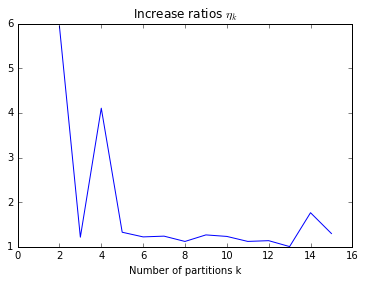

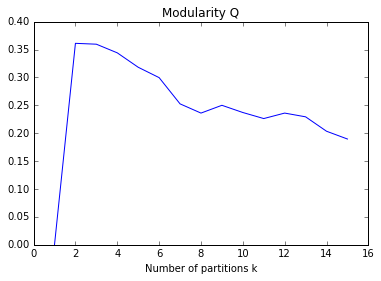

In [283]:
plt.title(r'Increase ratios $\eta_k$')
plt.plot(range(2, len(η) + 2),η)
plt.xlabel("Number of partitions k")
plt.xlim([0, N])
# plt.savefig("plots/toy_graph_eta")
plt.figure()
plt.title("Modularity Q")
plt.plot(range(1,N), Qs)
plt.xlabel("Number of partitions k")
# plt.savefig("plots/football_graph_Q")

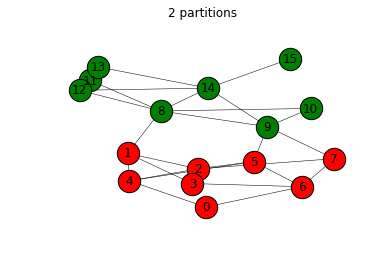

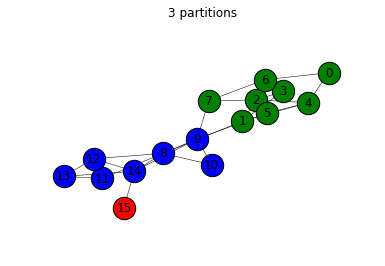

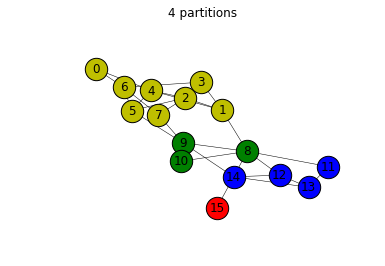

In [267]:
plt.title("2 partitions")
draw_graph(partitions[N-2], 2)
plt.figure()
plt.title("3 partitions")
draw_graph(partitions[N-3], 3)
plt.figure()
plt.title("4 partitions")
draw_graph(partitions[N-4], 4)

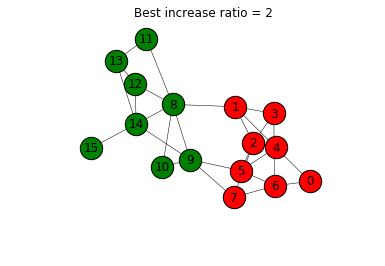

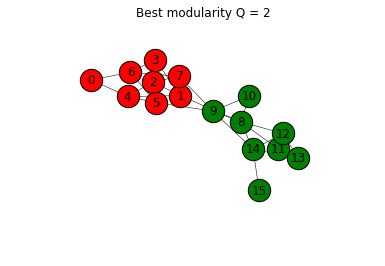

In [263]:
best_num_clusters = np.argmax(η[2:15]) + 2
plt.title("Best increase ratio = {}".format(best_num_clusters))
draw_graph(partitions[N-best_num_clusters], best_num_clusters)
# plt.savefig("plots/karate_graph_partition2")
# plt.savefig(filename="test.png", format="png")
plt.figure()
best_num_clusters_Qs = np.argmax(Qs[1:]) + 2
plt.title("Best modularity Q = {}".format(best_num_clusters_Qs))
draw_graph(partitions[N-best_num_clusters_Qs], best_num_clusters_Qs)
# plt.savefig("plots/karate_graph_partition4")

In [264]:
for i in range(12):
    print(list(np.where(cluster_assignements == i)[0]))

[8, 9, 10, 11, 12, 13, 14, 15]
[0, 1, 2, 3, 4, 5, 6, 7]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [223]:
for P in (list(partitions[N-12])):
    print(sorted(list(P)))

[20, 37, 42, 49, 50, 57, 63, 67, 75]
[16, 26, 27, 32, 34, 35, 58, 72, 77, 86, 109]
[0, 40, 46, 74, 85, 87, 90, 92, 98, 99]
[1, 3, 10, 28, 43, 78, 79, 91, 113]
[9, 23, 36, 44, 45, 66, 76, 83, 96, 106, 111, 114]
[2, 21, 24, 56, 69, 71, 84, 101]
[8, 11, 48, 59, 70, 88, 93, 102, 103]
[14, 18, 19, 22, 31, 38, 51, 54, 81, 82, 94, 105]
[5, 30, 33, 104, 108, 110]
[17, 41, 53, 80, 112]
[6, 7, 15, 25, 39, 47, 55, 60, 61, 62, 64, 65, 73, 89]
[4, 12, 13, 29, 52, 68, 95, 97, 100, 107]


In [226]:
[20, 37, 42, 49, 50, 57, 63, 67, 75]
[20, 37, 42, 49, 50, 57, 63, 67, 75]

[20, 37, 42, 49, 50, 57, 63, 67, 75]

In [227]:
[12, 13, 29, 52, 68, 95, 100, 107]
[4, 12, 13, 29, 52, 68, 95, 97, 100, 107] 

[4, 12, 13, 29, 52, 68, 95, 97, 100, 107]

In [228]:
[16, 26, 27, 32, 34, 35, 58, 72, 77, 86, 109]
[16, 26, 27, 32, 34, 35, 58, 72, 77, 86, 109]

[16, 26, 27, 32, 34, 35, 58, 72, 77, 86, 109]

In [229]:
[9, 23, 36, 44, 45, 66, 76, 83, 96, 106, 111, 114]
[9, 23, 36, 44, 45, 66, 76, 83, 96, 106, 111, 114]

[9, 23, 36, 44, 45, 66, 76, 83, 96, 106, 111, 114]

In [230]:
[8, 11, 48, 59, 70, 88, 91, 93, 102, 103]
[8, 11, 48, 59, 70, 88, 93, 102, 103]

[8, 11, 48, 59, 70, 88, 93, 102, 103]

In [244]:
[4, 6, 53, 97, 108]
[17, 41, 53, 80, 112]

[17, 41, 53, 80, 112]

In [237]:
[7, 15, 25, 39, 47, 55, 60, 61, 62, 64, 65, 73, 89]
[6, 7, 15, 25, 39, 47, 55, 60, 61, 62, 64, 65, 73, 89]

[6, 7, 15, 25, 39, 47, 55, 60, 61, 62, 64, 65, 73, 89]

In [236]:
[2, 21, 24, 56, 69, 71, 84, 101]
[2, 21, 24, 56, 69, 71, 84, 101]

[2, 21, 24, 56, 69, 71, 84, 101]

In [238]:
[0, 40, 46, 74, 85, 87, 90, 92, 98, 99]
[0, 40, 46, 74, 85, 87, 90, 92, 98, 99]

[0, 40, 46, 74, 85, 87, 90, 92, 98, 99]

In [239]:
[14, 18, 19, 22, 31, 38, 51, 54, 81, 82, 94, 105]
[14, 18, 19, 22, 31, 38, 51, 54, 81, 82, 94, 105]

[14, 18, 19, 22, 31, 38, 51, 54, 81, 82, 94, 105]

In [240]:
[5, 17, 30, 33, 41, 104, 112]
[5, 30, 33, 104, 108, 110]

[5, 17, 30, 33, 41, 104, 112]

In [243]:
[1, 3, 10, 28, 43, 78, 79, 80, 110, 113]
[1, 3, 10, 28, 43, 78, 79, 91, 113]

[1, 3, 10, 28, 43, 78, 79, 91, 113]

In [245]:
print(N)


115
